In [1]:
import pandas as pd
import pygmt
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Cargar los datos

In [3]:
data= pd.read_csv('events.csv')

In [4]:
data.head()

,ev_id,otime,loc,lat,lon,dep,mag,alert,url,ev_type,significance,year,date_str
0,uu60061837,2014-03-30 12:34:39.160,"22 km S of Mammoth, Wyoming",44.772167,-110.684667,5.62,4.83,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,700,2014,2014-03-30T12:34:39.160000Z
1,us20006umx,2016-08-27 20:47:47.240,"4 km ENE of Bondurant, Wyoming",43.222600,-110.359300,12.30,4.80,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,580,2016,2016-08-27T20:47:47.240000Z
2,uu60203137,2017-06-16 00:48:46.940,"12 km E of Hebgen Lake Estates, Montana",44.781333,-111.033167,9.30,4.36,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,346,2017,2017-06-16T00:48:46.940000Z
3,mb80153724,2016-06-13 12:14:39.050,"45 km W of Hebgen Lake Estates, Montana",44.730167,-111.763667,9.95,4.34,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,291,2016,2016-06-13T12:14:39.050000Z
4,uu60497322,2022-05-11 13:32:02.230,"36 km S of Silver Gate, Montana",44.681000,-109.996333,13.95,4.22,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,300,2022,2022-05-11T13:32:02.230000Z


### Poner los datos en otime

In [5]:
data['otime'] = pd.to_datetime(data['otime'])

print (data['otime'].min())
print (data['otime'].max())

2012-01-03 10:56:11.780000
2022-09-29 23:59:13.570000


**Sismos en el 2020**

In [6]:
t_0 = pd.to_datetime(f"{'2020-01-01'} 00:00:00.00")
t_f = pd.to_datetime(f"{'2021-01-01'} 00:00:00.00")

ix = (t_0 <= data['otime']) & (data['otime'] <= t_f)
ix[ix == True]

11       True
14       True
92       True
112      True
115      True
         ... 
23931    True
23942    True
23963    True
23970    True
23973    True
Name: otime, Length: 2230, dtype: bool

**Magnitud máxima de un sismo**

In [7]:
mag_max = data['mag'].max()
mag_max

4.83

### Distribución de magnitudes

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='mag', ylabel='Count'>

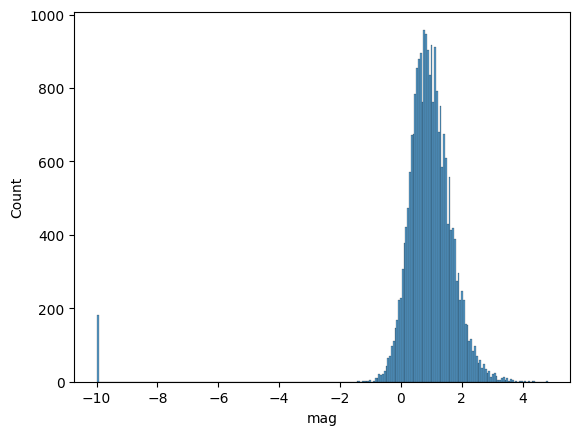

In [9]:
sns.histplot(data = data, x = 'mag')

**Vamos a eliminar outliers**

In [10]:
no_outliers = data['mag'] > -9.00
data = data[no_outliers]
data.head()

,ev_id,otime,loc,lat,lon,dep,mag,alert,url,ev_type,significance,year,date_str
0,uu60061837,2014-03-30 12:34:39.160,"22 km S of Mammoth, Wyoming",44.772167,-110.684667,5.62,4.83,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,700,2014,2014-03-30T12:34:39.160000Z
1,us20006umx,2016-08-27 20:47:47.240,"4 km ENE of Bondurant, Wyoming",43.222600,-110.359300,12.30,4.80,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,580,2016,2016-08-27T20:47:47.240000Z
2,uu60203137,2017-06-16 00:48:46.940,"12 km E of Hebgen Lake Estates, Montana",44.781333,-111.033167,9.30,4.36,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,346,2017,2017-06-16T00:48:46.940000Z
3,mb80153724,2016-06-13 12:14:39.050,"45 km W of Hebgen Lake Estates, Montana",44.730167,-111.763667,9.95,4.34,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,291,2016,2016-06-13T12:14:39.050000Z
4,uu60497322,2022-05-11 13:32:02.230,"36 km S of Silver Gate, Montana",44.681000,-109.996333,13.95,4.22,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,300,2022,2022-05-11T13:32:02.230000Z


<Axes: xlabel='mag', ylabel='Count'>

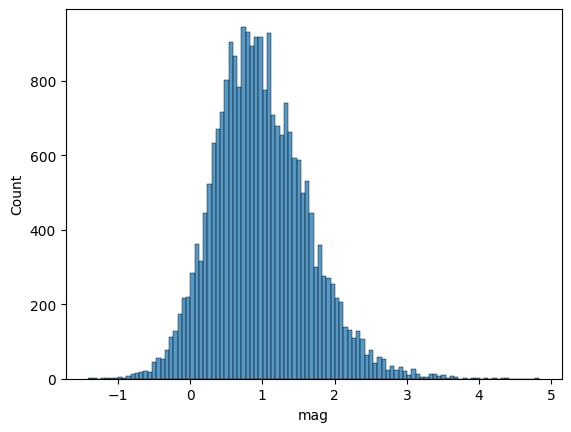

In [11]:
sns.histplot(data = data, x = 'mag')

## Magnitud de completitud

La **Magnitud de Completitud (Mc)** Es la magnitud mínima por encima de la cual se registran de forma fiable todos los terremotos de una región determinada. Este valor es variable en el tiempo y en el espacio. Diferentes regiones tienen una Mc diferente, y ese valor ha cambiado a lo largo del tiempo.

Existen varios métodos para determinar la Mc, en este caso se usará el método de Máxima Curvatura (MAXC), donde se calcula **valor máximo de la primera derivada de la curva frecuencia-magnitud**.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Definir rango de magnitudes
# El step size fue definido a prueba y error, tal que cumulative_freq y mag_range tuvieran el mismo tamaño
mag_range = np.arange(min(data['mag']), max(data['mag']), 0.01374) 

#Calcular la frecuencia de cada magnitud

freq = data['mag'].value_counts().sort_index()

# Frecuencia acumulativa
cumulative_freq = np.cumsum(freq[::-1])[::-1]

# Calcular la derivada de la curva frecuencia-magnitud.
derivative = np.diff(cumulative_freq) / np.diff(mag_range)

# La magnitud de completitud es la correspondiente al valor máximo de la primera derivada
Mc = mag_range [np.argmin(derivative)]

print('Magnitud de completitud:', Mc)

Magnitud de completitud: 1.4341800000000176


## Ley de Gutenberg - Ritcher

La ley de Gutenberg-Richter es un principio fundamental de la sismología. Establece que el logaritmo del número de terremotos con una magnitud mayor o igual a un determinado valor es linealmente proporcional al negativo de dicha magnitud. La ecuación es:

$$\log_{10}N(M) = a - b(M - Mc); M \geq Mc$$

Donde:
- $Mc$ es la Magnitud de Completitud.
- $a$ es el logaritmo del número total de terremotos con magnitud $M \geq M1$.
- $b$ es una constante que relaciona el número relativo de magnitudes pequeñas con el de magnitudes grandes.

El método Aki es una forma de calcular el valor $b$ de la siguiente manera:

$$b = \log_{10}e(\overline{M} - Mc)$$

donde $\overline{M}$ es la magnitud media observada.

In [13]:
def calculate_b_value(data, Mc):
    # Filtra los sismos de magnitud inferior a la magnitud de completitud
    data = data[data['mag'] >= Mc]

    # Calcular la magnitud media por encima de Mc
    mean_mag = np.mean(data['mag'])

    # Calcular el valor b
    b_value = (1 / (mean_mag - Mc)) * np.log10(np.exp(1))

    return b_value

b_value = calculate_b_value(data, Mc)
print(f"b es igual a: {b_value}")


b es igual a: 0.9658481902465883


Para calcular el parámetro `a` de la ley de Gutenberg-Richter a partir de este **dataframe**, se puede utilizar la siguiente fórmula:

$$a = \log_{10}N + bM_c$$

donde:
- $N$ es el número total de sucesos con magnitud mayor o igual que $M_c$,
- $b$ es el parámetro de escala calculado anteriormente,
- $M_c$ es la magnitud de completitud calculada anteriormente.

Utilizando los valores ya calculados, podemos calcular `a` de la siguiente manera:

In [14]:
def calculate_a_value(data, Mc, b_value):
    # Filtra los sismos de magnitud inferior a la magnitud de completitud
    data = data[data['mag'] >= Mc]

    # Calcular el número total de sismos con magnitud >= Mc
    N = len(data)

    # Calcular el valor de a
    a_value = np.log10(N) + b_value * Mc

    return a_value

a_value = calculate_a_value(data, Mc, b_value)
print(f"a es igual a: {a_value}")


a es igual a: 5.124535117683949


In [15]:
data_mc = data[data['mag'] >= Mc]
data_mc.tail() #Ver los 5 valores más bajos de magnitud


,ev_id,otime,loc,lat,lon,dep,mag,alert,url,ev_type,significance,year,date_str
5482,uu60329077,2019-07-03 15:56:09.890,"34 km E of West Yellowstone, Montana",44.639500,-110.672833,5.03,1.44,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,32,2019,2019-07-03T15:56:09.890000Z
5483,uu60225997,2017-08-15 04:59:29.060,"28 km ESE of West Yellowstone, Montana",44.572333,-110.766833,4.76,1.44,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,32,2017,2017-08-15T04:59:29.060000Z
5484,mb80166989,2016-08-28 00:28:40.280,"15 km NE of Bondurant, Wyoming",43.285000,-110.250000,6.03,1.44,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,32,2016,2016-08-28T00:28:40.280000Z
5485,uu60039987,2013-10-04 07:21:26.440,"7 km ESE of Hebgen Lake Estates, Montana",44.747500,-111.097333,11.69,1.44,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,32,2013,2013-10-04T07:21:26.440000Z
5486,uu60029374,2021-10-28 03:30:09.850,"37 km S of Silver Gate, Montana",44.671333,-110.046000,14.37,1.44,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,32,2021,2021-10-28T03:30:09.850000Z


### Datos reales de N vs Magnitud

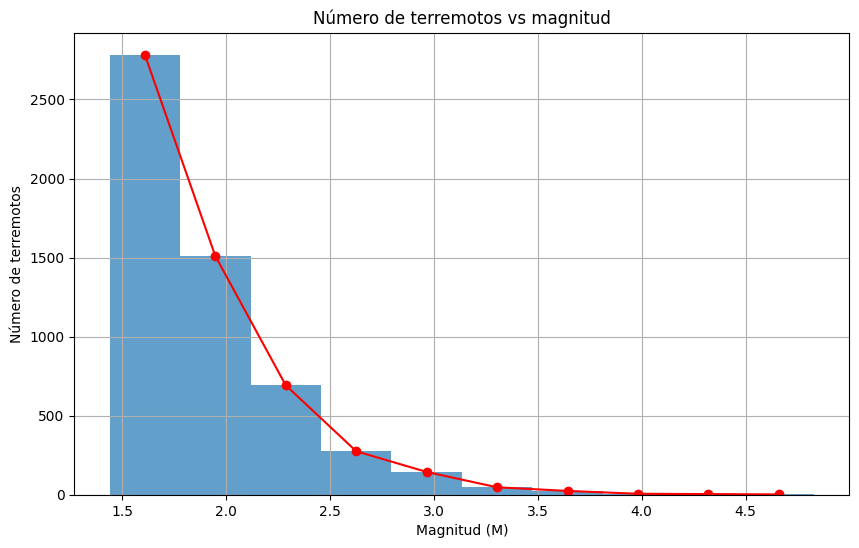

In [16]:
# Calcula el histograma de los datos con la función histograma de numpy
counts, bins = np.histogram(data_mc['mag'])

# Calcula los centros de los bins
bin_centers = (bins[1:] + bins[:-1]) / 2

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=np.diff(bins), align='center', alpha=0.7) # trazar histograma
plt.plot(bin_centers, counts, marker='o', linestyle='-', color='r') # trazar línea que pasa por cada punto
plt.xlabel('Magnitud (M)')
plt.ylabel('Número de terremotos')
plt.title('Número de terremotos vs magnitud')
plt.grid(True)
plt.show()

## Curva teórica de N vs Magnitud con los valores calculados para $a$, $b$ y $Mc$

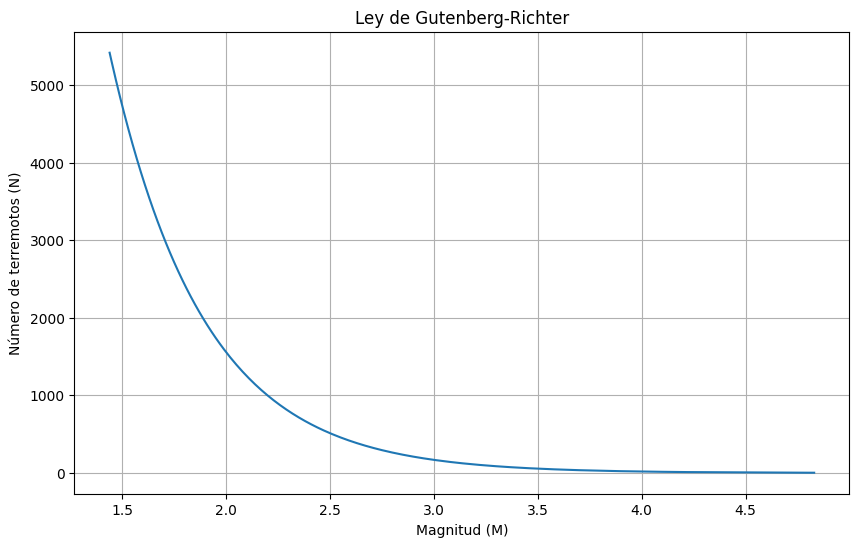

In [17]:
a = a_value 
b = b_value 
M = data_mc['mag'] 

# Calcular N
N = 10**(a - b * M)

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(M, N)
plt.xlabel('Magnitud (M)')
plt.ylabel('Número de terremotos (N)')
plt.title('Ley de Gutenberg-Richter')
plt.grid(True)
plt.show()

# Mapa en PyGMT

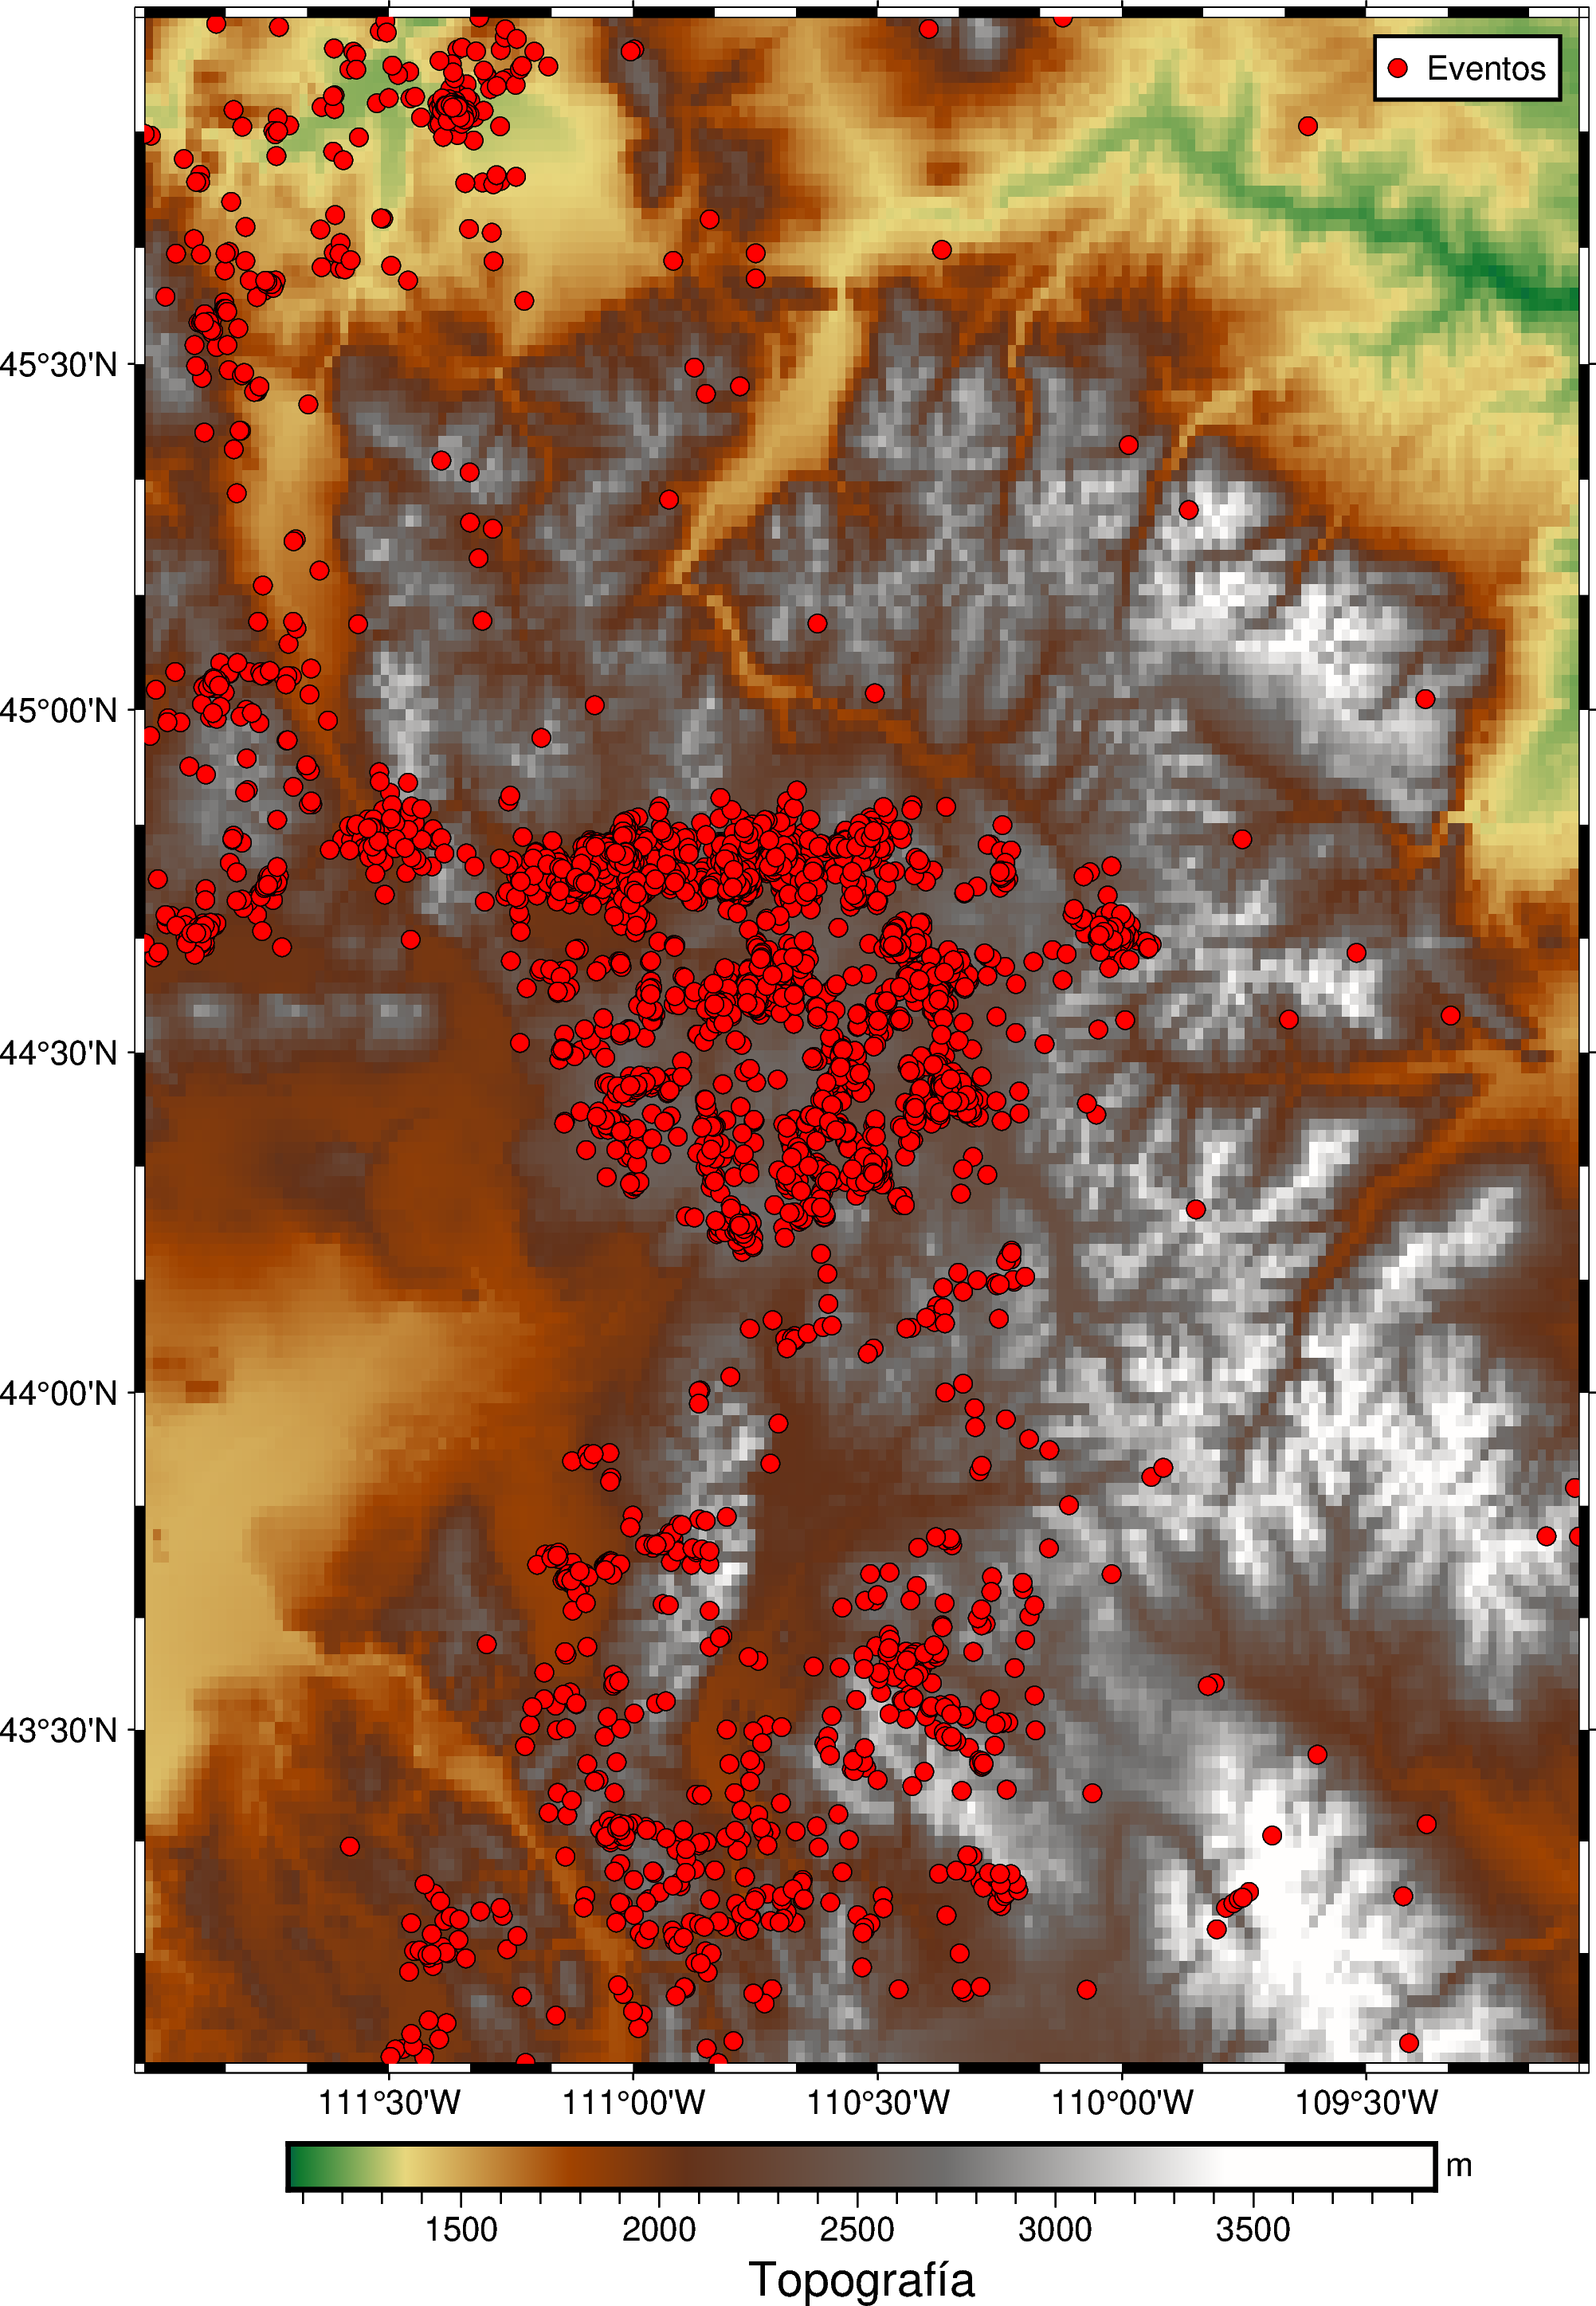

In [20]:
# Filtrar eventos con magnitud mayor que la magnitud de completitud
df = data_mc

# Crear una nueva figura PyGMT
fig = pygmt.Figure()

# Definir la región de interés
region = [df['lon'].min(), df['lon'].max(), df['lat'].min(), df['lat'].max()]

# Generar topografía utilizando el conjunto de datos 'earth relief'
fig.grdimage('@earth_relief_01m', region=region, projection='M6i', cmap='geo')

# Agregar una cuadrícula de coordenadas
fig.basemap(region=region, projection='M6i', frame=True)

# Graficar eventos en el mapa
fig.plot(
    x=df['lon'],
    y=df['lat'],
    style='c0.2c',
    color='red',
    pen='black',
    label='Eventos'
)

# Agregar una barra de colores para la topografía
fig.colorbar(frame=['+L"Topografía"', 'xaf', 'y+l"m"'])

# Agregar una leyenda para los eventos
fig.legend(position='jTR+o0.2c', box='+gwhite+p1p')

# Mostrar el gráfico
fig.show()
